# US vs. India sector distribution

We use market cap data provided by IEX for US equities and BSE for Indian equities to plot the total market caps of listed equities.

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(pracma)
library(ggthemes)
library(reshape2)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)
library(ggpubr)

options(repr.plot.width=16, repr.plot.height=8)
options(tibble.width = Inf)

#initialize
equitiesIndiaBse <- EquitiesIndiaBse()
equitiesUs <- EquitiesUs()

## Gather US data

In [2]:
mktCapStatsUs <- equitiesUs$Tickers() %>%
    filter(MKT_CAP > 0) %>%
    select(MKT_CAP) %>%
    collect() %>%
    summarize(MEDIAN = median(MKT_CAP), MEAN = mean(MKT_CAP), MIN = min(MKT_CAP), MAX = max(MKT_CAP), N = n()) 

print("summary statistics: ")
mktCapStatsUs %>% print()

medianMktCapUs <- mktCapStatsUs$MEAN[[1]]

print("number of stocks with market-cap greater than the average: ")
equitiesUs$Tickers() %>% filter(MKT_CAP >= medianMktCapUs) %>% summarize(N = n())

[1] "summary statistics: "
# A tibble: 1 x 5
     MEDIAN        MEAN     MIN           MAX     N
      <dbl>       <dbl>   <dbl>         <dbl> <int>
1 772082080 8066093637. 1385556 1051625019300  4533
[1] "number of stocks with market-cap greater than the average: "


# Source:   lazy query [?? x 1]
# Database: NORWAY:StockVizUs2:R
      N
  <int>
1   691

In [3]:
# aggregate by SEC's industry classification
top50Us <- equitiesUs$Tickers() %>%
    inner_join(equitiesUs$SecMeta(), by=c('SYMBOL')) %>%
    filter(MKT_CAP >= medianMktCapUs) %>%
    group_by(SIC_DESC) %>%
    summarize(CAP = sum(MKT_CAP)) %>%
    collect() %>%
    arrange(desc(CAP)) %>%
    as.data.frame()

In [16]:
print(head(top50Us[,1], 50))

 [1] "SERVICES-COMPUTER PROGRAMMING, DATA PROCESSING, ETC."               
 [2] "SERVICES-PREPACKAGED SOFTWARE"                                      
 [3] "PHARMACEUTICAL PREPARATIONS"                                        
 [4] "NATIONAL COMMERCIAL BANKS"                                          
 [5] "SERVICES-BUSINESS SERVICES, NEC"                                    
 [6] "REAL ESTATE INVESTMENT TRUSTS"                                      
 [7] "ELECTRONIC COMPUTERS"                                               
 [8] "RETAIL-CATALOG &amp; MAIL-ORDER HOUSES"                             
 [9] "SEMICONDUCTORS &amp; RELATED DEVICES"                               
[10] "PETROLEUM REFINING"                                                 
[11] "CABLE &amp; OTHER PAY TELEVISION SERVICES"                          
[12] "RETAIL-VARIETY STORES"                                              
[13] "TELEPHONE COMMUNICATIONS (NO RADIO TELEPHONE)"                      
[14] "ELECTRIC SERVICES" 

## Gather India data

In [5]:
miscDate <- as.Date((equitiesIndiaBse$MiscInfo() %>% summarize(MAX = max(TIME_STAMP)) %>% collect())$MAX[[1]])
mktCapStatsIn <- equitiesIndiaBse$MiscInfo() %>%
    filter(TIME_STAMP == miscDate & FULL_MKT_CAP_CR > 0) %>%
    select(MKT_CAP = FULL_MKT_CAP_CR) %>%
    collect() %>%
    summarize(MEDIAN = median(MKT_CAP), MEAN = mean(MKT_CAP), MIN = min(MKT_CAP), MAX = max(MKT_CAP), N = n()) 

print("summary statistics: ")
mktCapStatsIn %>% print()

medianMktCapIn <- mktCapStatsIn$MEAN[[1]]

print("number of stocks with market-cap greater than the average: ")
equitiesIndiaBse$MiscInfo() %>% filter(TIME_STAMP == miscDate & FULL_MKT_CAP_CR >= medianMktCapIn) %>% summarize(N = n())

[1] "summary statistics: "
# A tibble: 1 x 5
  MEDIAN  MEAN   MIN     MAX     N
   <dbl> <dbl> <dbl>   <dbl> <int>
1   133. 5538.  0.27 829633.  2659
[1] "number of stocks with market-cap greater than the average: "


# Source:   lazy query [?? x 1]
# Database: NORWAY:StockViz:R
      N
  <int>
1   305

In [6]:
# aggregate by BSE's industry classification
top50In <- equitiesIndiaBse$Tickers() %>%
    inner_join(equitiesIndiaBse$MiscInfo(), by=c('CODE')) %>%
    filter(TIME_STAMP == miscDate & FULL_MKT_CAP_CR >= medianMktCapIn) %>%
    group_by(INDUSTRY) %>%
    summarize(CAP = sum(FULL_MKT_CAP_CR)) %>%
    collect() %>%
    arrange(desc(CAP)) %>%
    as.data.frame()

In [15]:
print(head(top50In[,1], 50))

 [1] "Banks"                        "IT Consulting & Software"    
 [3] "Integrated Oil & Gas"         "Personal Products"           
 [5] "Pharmaceuticals"              "Finance (including NBFCs)"   
 [7] "Housing Finance"              "Electric Utilities"          
 [9] "Cement & Cement Products"     "Cigarettes-Tobacco Products" 
[11] "Life Insurance"               "Cars & Utility Vehicles"     
[13] "Furniture-Furnishing-Paints"  "Packaged Foods"              
[15] "Construction & Engineering"   "2/3 Wheelers"                
[17] "Holding Companies"            "Oil Marketing & Distribution"
[19] "Telecom Services"             "Exploration & Production"    
[21] "Other Apparels & Accessories" "Department Stores"           
[23] "Auto Parts & Equipment"       "Refineries/ Petro-Products"  
[25] "Heavy Electrical Equipment"   "Zinc"                        
[27] "Iron & Steel/Interm.Products" "Coal"                        
[29] "Realty"                       "General Insurance"       

## plot industry vs. market cap

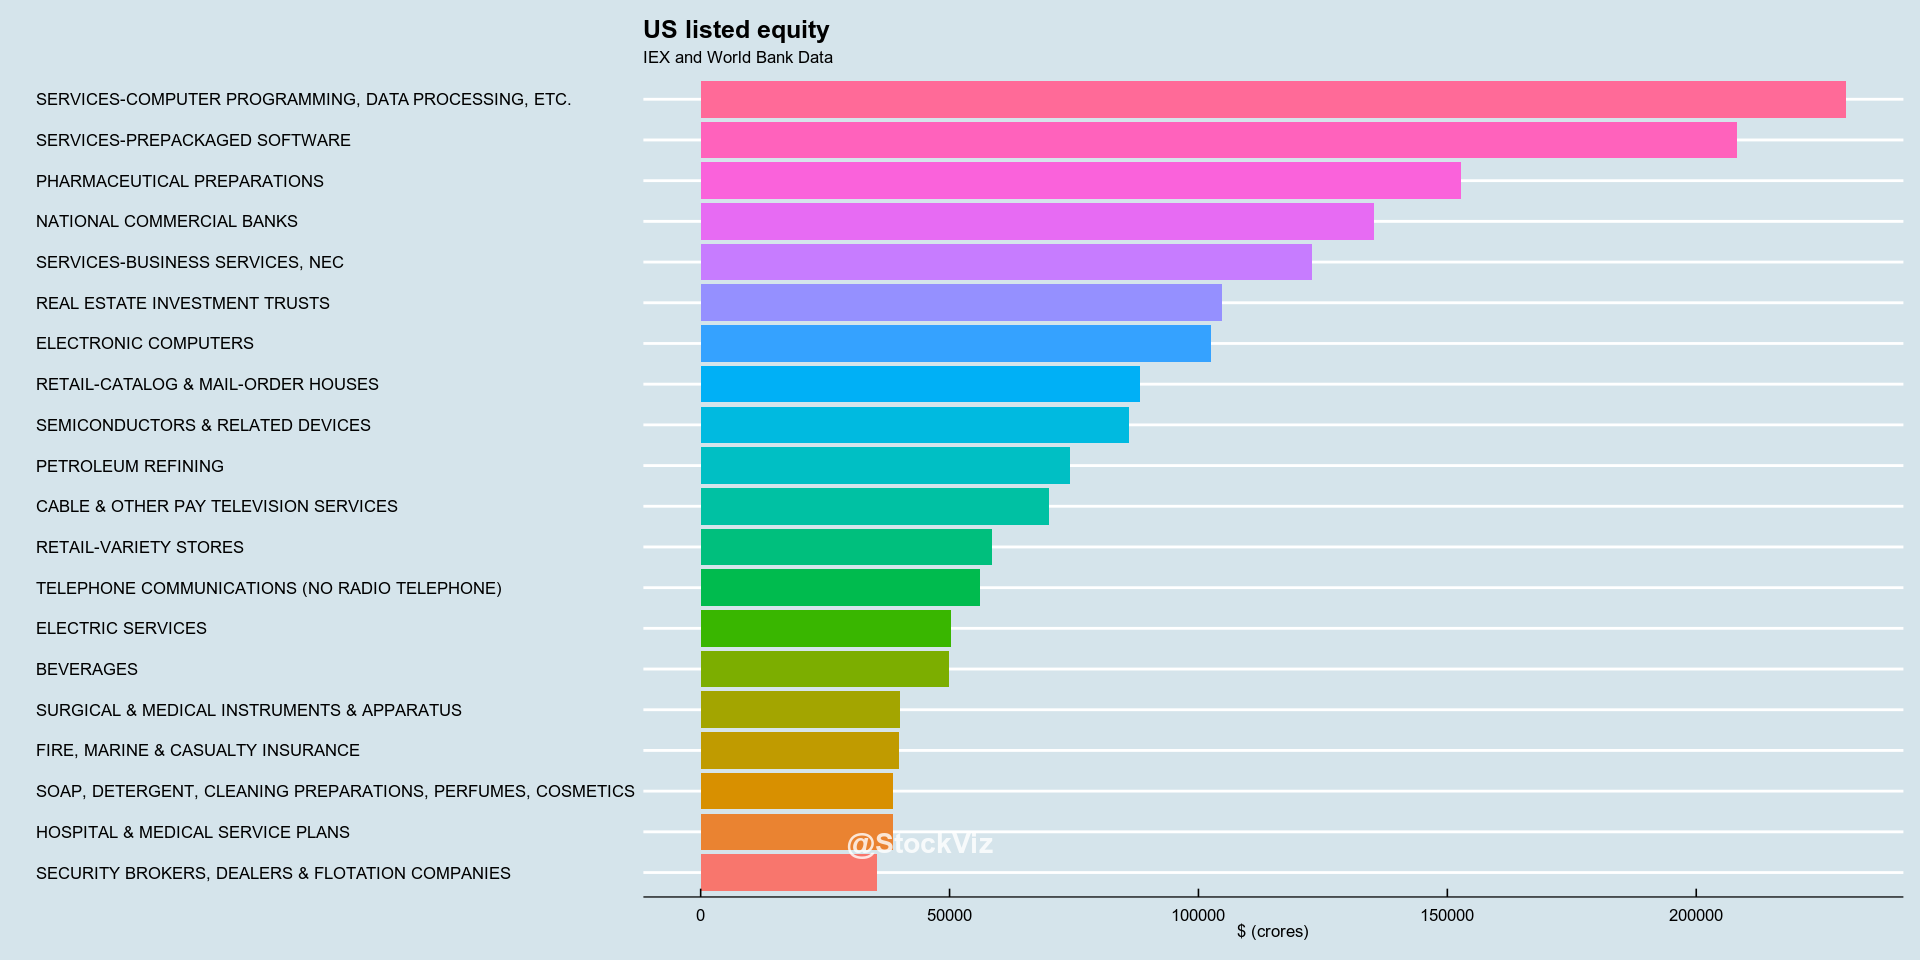

In [8]:
toPlot <- head(top50Us, 20)
toPlot <- toPlot[order(toPlot$CAP, decreasing=F),]
toPlot$SIC_DESC <- gsub("&amp;", "&", toPlot$SIC_DESC)
toPlot$SIC_DESC <- factor(toPlot$SIC_DESC, levels = toPlot$SIC_DESC)
toPlot$CAP <- round(toPlot$CAP/10000000, 2) #convert to crores

ggplot(toPlot, aes(x=SIC_DESC, y=CAP, fill=SIC_DESC)) +
    theme_economist() +
    geom_bar(stat="identity", position=position_dodge()) +
    guides(fill=F) +
    coord_flip() +
    labs(x='', y='$ (crores)', fill='', title="US listed equity", 
         subtitle="IEX and World Bank Data") +
    annotate("text", x=1, y=0, 
             label = "@StockViz", hjust=-1, vjust=-1, 
             col="white", cex=6, fontface = "bold", alpha = 0.8)  

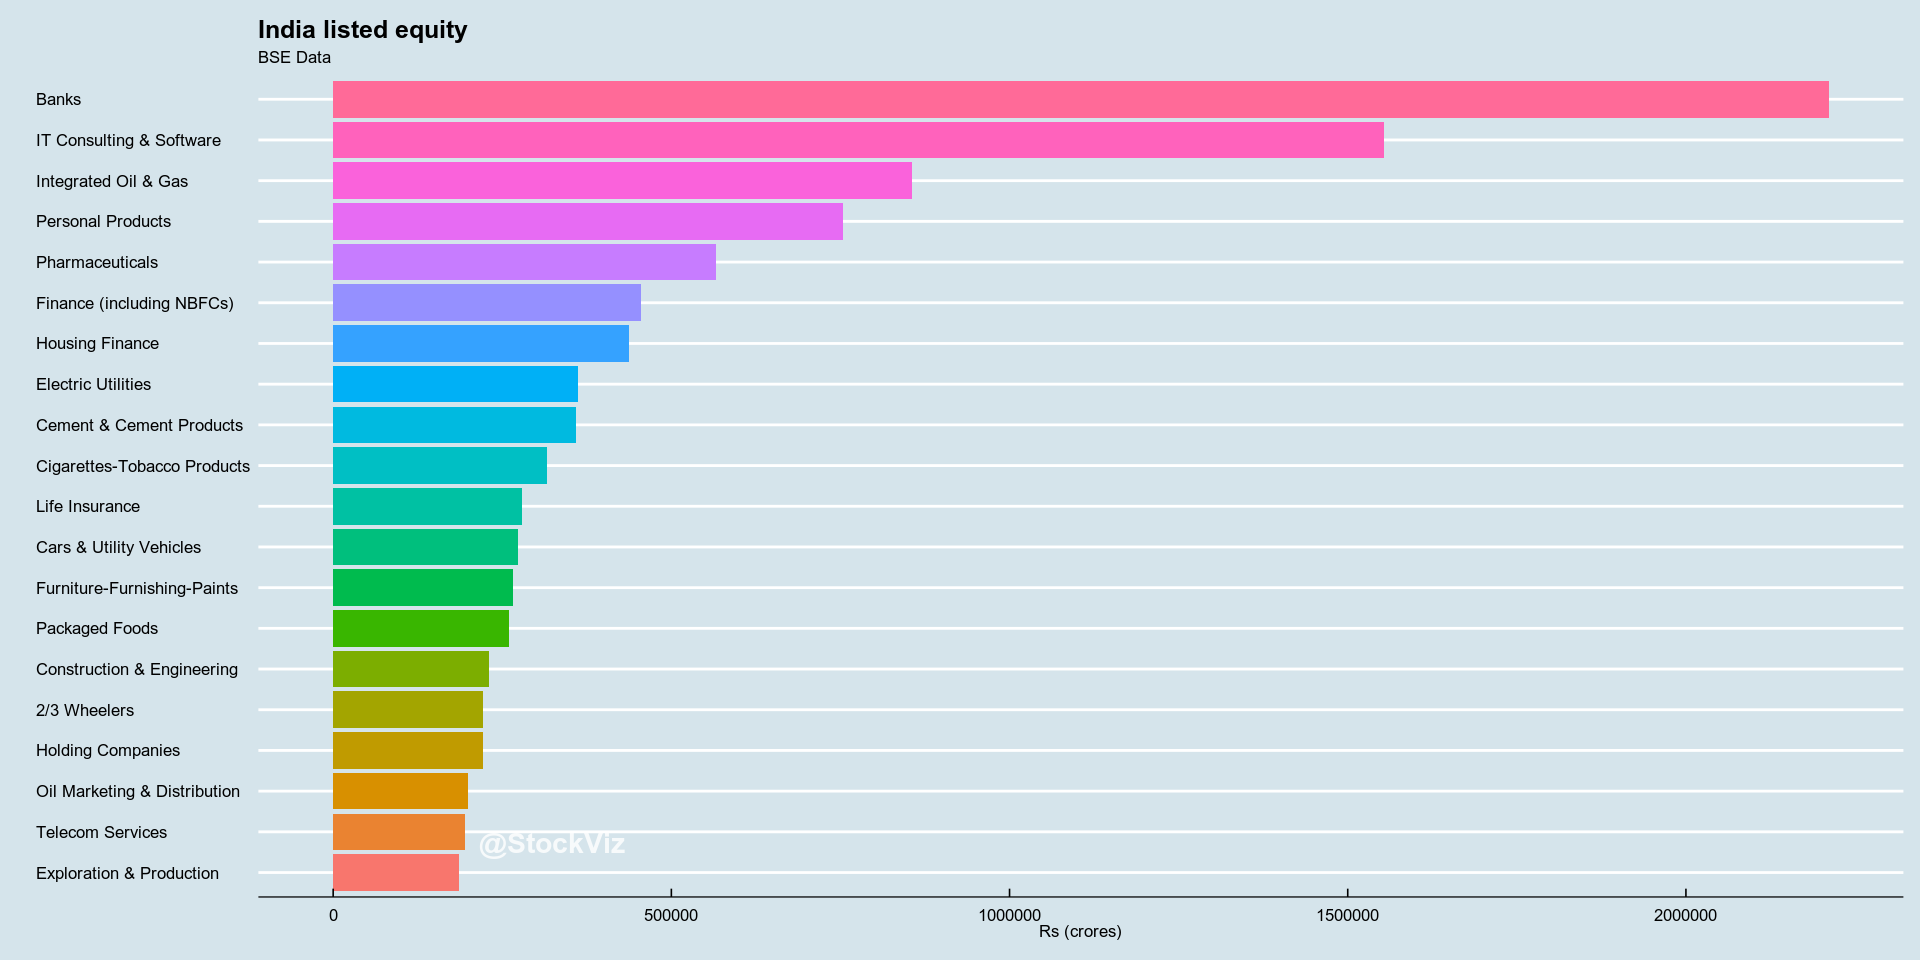

In [9]:
toPlot <- head(top50In, 20)
toPlot <- toPlot[order(toPlot$CAP, decreasing=F),]
toPlot$INDUSTRY <- gsub("&amp;", "&", toPlot$INDUSTRY)
toPlot$INDUSTRY <- factor(toPlot$INDUSTRY, levels = toPlot$INDUSTRY)
toPlot$CAP <- round(toPlot$CAP, 2) #already in crores

ggplot(toPlot, aes(x=INDUSTRY, y=CAP, fill=INDUSTRY)) +
    theme_economist() +
    geom_bar(stat="identity", position=position_dodge()) +
    guides(fill=F) +
    coord_flip() +
    labs(x='', y='Rs (crores)', fill='', title="India listed equity", 
         subtitle="BSE Data") +
    annotate("text", x=1, y=0, 
             label = "@StockViz", hjust=-1, vjust=-1, 
             col="white", cex=6, fontface = "bold", alpha = 0.8)  

This notebook was created using [pluto](https://pluto.studio). Thank you for playing fair!